# Fast.ai Part 1
> Notes for lessons 1-3 of Fast.ai and a small project

- toc: true 
- badges: true
- comments: true
- categories: [fastai, project]
- image: images/chart-preview.png

# Lesson Summary

The first three lessons of the Fast.ai course focus on giving you a high level overview of the course, explain the reason for their top down approach, as well as begin to define some terms, and show some examples. The top down approach means they put a focus in the very beginning to demonstrate the capabilities of machine learning programs, and only once an idea is established will they begin to go into details of how it all ends up working and can be implemented. Before they jump into examples though, there is a section in Lesson 1 where they give a brief overview of what and how a machine learning program is trained.

For those who are learning about machine learning and how neural networks work for the first time, there are many explanations online that are more clear than I could describe it, but I think the most illustrative example is this video by 3Blue1Brown:

> youtube: https://youtu.be/aircAruvnKk


The concepts in the video above are beyond what is necessary for the first few lessons, but it's a great representation of what is going on. Beyond the history of machine learning, it includes some demos that introduce the Fast.ai library and show how easy it is to train a neural network to recognize the difference between cats and dogs, or to classify different types of bears from data that was obtained through a Bing search.

The lessons do walk you through all the steps of how to set it all up yourself, but when everything is pretyped for you and the only input you need is to shift-enter through it all, it's easy to gloss over it and not learn what any of the parameters are or what is happening, even at a high level. This will be my attempt at implementing a simple image classifier.

# My Side Project

The goal of this project is to be able to take a screenshot of a game of Valorant, and determine what agent they are playing. For those unfamiliar with the game, the only thing you need to know is that there are multiple different characters - referred to as agents - that you can play, and the only indication for an observer to know which one you're playing is by the icons along the bottom of the screen as seen here:

![](../images/valorant_screenshot.png)

The idea of this is to be able to use this classifier to enhance a directory of Valorant streamers by displaying what agent the person is playing without having to load up multiple streams to find the one you're looking for.

### Gathering the Data

To gather the data, I built a web scraper that loads up various Twitch streams and takes a screenshot of the video portion and saves it off. If you're curious about the code to do this, [view it here](https://github.com/JordanBourne/TwitchScreenGrab)

After my first run of this, I ended up with a little over 300 screenshots that I sorted into folders under the respective agent name, uploaded it to my Paperspace Jupyter notebook, and gave it a run.

In [1]:
#hide
from utils import *
from fastai.imports import *
from fastai.vision.all import *

First up is the importing of images, and the cropping.

In [2]:
path = Path('../training_data/valorant_agents')
fns = get_image_files(path)
fns

(#326) [Path('../training_data/valorant_agents/omen/stream_3_8_screenshot.png'),Path('../training_data/valorant_agents/omen/stream_8_7_screenshot.png'),Path('../training_data/valorant_agents/omen/stream_25_9_screenshot.png'),Path('../training_data/valorant_agents/omen/stream_21_7_screenshot.png'),Path('../training_data/valorant_agents/omen/stream_3_7_screenshot.png'),Path('../training_data/valorant_agents/omen/stream_3_6_screenshot.png'),Path('../training_data/valorant_agents/omen/stream_8_1_screenshot.png'),Path('../training_data/valorant_agents/omen/stream_21_6_screenshot.png'),Path('../training_data/valorant_agents/omen/stream_3_1_screenshot.png'),Path('../training_data/valorant_agents/omen/stream_8_6_screenshot.png')...]

In [27]:
i = 1000
for full_image_path in fns:
    full_image = Image.open(full_image_path)
    cropped = full_image.crop((320,500,686,580))
    agent = parent_label(full_image_path)
    cropped.save('../training_data/valorant_agents_cropped/' + agent + '/' + agent + '_' + str(i) + '.png')
    i += 1

### Preparing the Data
Next, we need to set up the dataloaderwith the correct hyperparameters for our training scenario.

In [19]:
agents = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.1, seed=42),
    get_y=parent_label
#     item_tfms=Resize(128)
)

 - `blocks`: Here we define the transforms to be used to turn our images into data that can be trained on
 - `get_items`: The function that is used to grab the data from a path. In this case, `get_image_files` only looks for files that end with an image file extension within the path specified later.
 - `splitter`: We get a choice to define here a few different data splitters. The one used here, `RandomSplitter` will split our images into 90% training data and 10% validation data.
 - `get_y`: This needs a getter of some kind to know how to get the propper label for the data. Our choice of `parent_label` means the label is determined by the name of the parent folder the image is located in.
 - `item_tfms`: The item transformer is a standard transform that is applied to each image. It's normally a standard to transform each image into a 128x128 square, for example, but in this case all of my images are already cropped to a small rectangle so it's commented out.

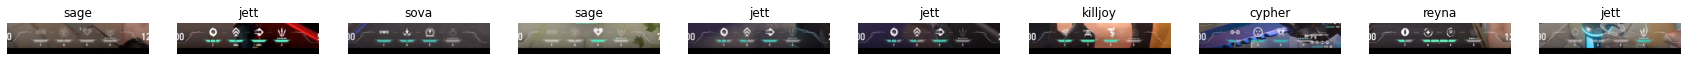

In [20]:
path_cropped = Path('../training_data/valorant_agents_cropped/')
dls = agents.dataloaders(path_cropped)
dls.valid.show_batch(max_n=10, nrows=1)

The data is now loaded and we can take a quick preview of it to verify it looks alright.

### Training the Model

In [21]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,2.404506,2.224117,0.843750,00:54
1,1.874344,1.475777,0.500000,00:53
2,1.386886,0.800763,0.250000,00:54
3,1.062970,0.543527,0.187500,00:53
4,0.843841,0.466695,0.125000,00:53
5,0.680627,0.453754,0.156250,00:53
6,0.564731,0.460995,0.125000,00:53
7,0.477119,0.472657,0.125000,00:53
8,0.410234,0.493396,0.125000,00:54
9,0.357674,0.496219,0.125000,00:53


### Results

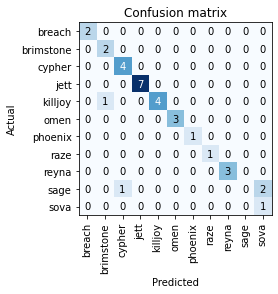

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

After running this a bunch of times, playing with the hyperparameters (such as the number of epochs, the random seed it started with, and how the data was split) and examining the results, it seems with the initial data that I colleced it was fairly consistantly setting around an 80-90% success rate. Also with further examination, it seemed to struggle in particular with the less popular agents because of a general lack of data in that section.

### Second Run

I took a slightly different approach to collecting the second set of data. The second time around I sought out specific streamers playing the agents I needed more data for, and modified my script to just grab screenshots from those streams. I rounded out the data set as a whole, and in the end my total training set was over 1000 images.

In [25]:
#collapse-hide
#prepping the second batch of data
path = Path('../training_data/valorant_agents_2')
fns = get_image_files(path)
i = 2000
for full_image_path in fns:
    full_image = Image.open(full_image_path)
    cropped = full_image.crop((320,500,686,580))
    agent = parent_label(full_image_path)
    cropped.save('../training_data/valorant_agents_cropped/' + agent + '/' + agent + '_' + str(i) + '.png')
    i += 1

agents = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.1, seed=42),
    get_y=parent_label
#     item_tfms=Resize(128)
)

path_cropped = Path('../training_data/valorant_agents_cropped/')
dls = agents.dataloaders(path_cropped)

In [24]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.963583,0.222032,0.070175,03:20
1,0.479458,0.125853,0.035088,03:17
2,0.283987,0.122576,0.026316,03:15
3,0.185935,0.119295,0.026316,03:14


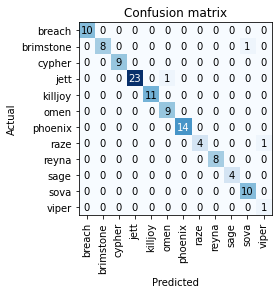

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Final Results

With the increase in the size of the data set, we've been able to increate the success rate to over 97% with just a few generations of testing. Were I to run this experiment again, I think I'd try to be much more deliberate about the data collection process. For this data set, it was collected fairly at random, which resulted in me needing a much larger data set. If I instead had loaded up the game myself and taken a few different screenshots for each agent for each state it could be in, or perhaps just limit it to one of the four possible icons for each agent, since each is distinct.